In [1]:
import os
from pathlib import Path

import pandas as pd

## Display settings

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 150

## Input configuration

### Dataset description
TODO

In [3]:
# OFF ~ open food facts
OFF_DUMP_PATH = '/Users/rgareev/data/openfoodfacts/20220831/en.openfoodfacts.org.products.csv'

In [5]:
COLUMNS_TO_USE = [
    'code',
    'product_name',
    'nova_group',
    'ingredients_tags',
]

### Preprocessing configuration

In [6]:
param_minimum_ingredient_freq = 20

# Output configuration

In [7]:
OUTPUT_DIR = '/Users/rgareev/data/openfoodfacts/wrk/20220831-dev'

# Script

## Ingest data

In [8]:
df = pd.read_csv(OFF_DUMP_PATH, sep='\t', usecols=COLUMNS_TO_USE, index_col='code')
df.info(memory_usage='deep')

/var/folders/pz/cbnfbk_j37v9vqmn8s0t711c0000gn/T/ipykernel_73892/2724890461.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(OFF_DUMP_PATH, sep='\t', usecols=COLUMNS_TO_USE, index_col='code')


<class 'pandas.core.frame.DataFrame'>
Index: 2508100 entries, 00000000000000225 to 999999999999999
Data columns (total 3 columns):
 #   Column            Dtype  
---  ------            -----  
 0   product_name      object 
 1   ingredients_tags  object 
 2   nova_group        float64
dtypes: float64(1), object(2)
memory usage: 701.1 MB


In [9]:
from collections import Counter
pd.Series(type(i) for i in df.index).value_counts()

<class 'int'>    1720320
<class 'str'>     787780
dtype: int64

In [10]:
# for simplicity - make everything str in index
df.set_index(df.index.astype(str), inplace=True)
df.index

Index(['00000000000000225', '0000000000000207025004', '00000000000003429145',
       '00000000000026772226', '0000000000017', '0000000000031',
       '000000000003327986', '000000000004128579', '000000000004622327',
       '00000000001',
       ...
       '9999999168505', '9999999175305', '99999995', '9999999900686',
       '9999999901', '9999999910128', '999999999', '9999999990397',
       '9999999999994', '999999999999999'],
      dtype='object', name='code', length=2508100)

## Preprocess data

### Clean data

In [11]:
df.dropna(subset=['ingredients_tags', 'nova_group'], inplace=True)
df.shape

(676995, 3)

Convert `nova_group` (our target variable to predict) to integers

In [12]:
df.nova_group.value_counts(dropna=False)

4.0    454546
3.0    136087
1.0     73371
2.0     12991
Name: nova_group, dtype: int64

In [13]:
df['nova_group'] = df['nova_group'].astype("int8")
df.nova_group.value_counts()

4    454546
3    136087
1     73371
2     12991
Name: nova_group, dtype: int64

Prepare ingredients attribute
* Parse string to list
* Remove non-english
* Remove rare
* Filter the dataframe records with no ingredients

In [14]:
df.sample(n=10)

,product_name,ingredients_tags,nova_group
code,,,
5035766044833,"Apple cider, Elderflower","en:cider,en:alcohol,en:glucose-fructose-syrup,...",4
4016931020563,Hubauer ACE orange-carrot-lemon vitamindrink,"en:mineral-water,en:water,en:orange-juice,en:f...",4
8008110259259,Chicken nuggets,"en:chicken-meat,en:poultry,en:chicken,en:wheat...",4
4388844177314,Fettarme H-Milch,"en:milk,en:dairy",1
7616500605671,Prestige Noir,"en:sugar,en:added-sugar,en:disaccharide,en:coc...",4
30000561829,Dark chocolate cherry & cashews nut & fruit ba...,"en:almond,en:nut,en:tree-nut,en:dark-chocolate...",4
3700662759366,"Pâte à tartiner aux noisettes, chocolat noir e...","en:hazelnut,en:nut,en:tree-nut,en:dark-chocola...",3
3276550572039,5 pains au chocolat + 5 croissants ordinaires,"fr:pains-au-chocolat,en:water,en:oil-and-fat,e...",4
3245412886232,Coquillettes cuisson rapide 3 minutes,"en:superior-quality-durum-wheat-semolina,en:ce...",1


In [15]:
df['ingredients_list'] = df.ingredients_tags.str.split(',')
df.ingredients_list.sample(n=10)

code
3222476786005    [en:wheat-flour, en:cereal, en:flour, en:wheat...
3663787452188    [fr:aloe-vera-gel, en:fructose, en:added-sugar...
42390831         [en:wheat-flour, en:cereal, en:flour, en:wheat...
4388844079847    [de:zutaten, en:corn-starch, en:starch, en:cor...
2643313039886    [en:pork-meat, en:animal, en:meat, en:pork, en...
50428479407      [en:sugar, en:added-sugar, en:disaccharide, en...
7616700234190    [en:wheat-flour, en:cereal, en:flour, en:wheat...
70227504032      [en:spelt-matzo-meal, en:salt, en:onions-monoc...
9300677007984                           [en:honey, en:added-sugar]
38000111136      [en:puffed-rice, en:rice, en:sugar, en:added-s...
Name: ingredients_list, dtype: object

In [16]:
del df['ingredients_tags']

In [17]:
ing_list_len_ss = df.ingredients_list.map(len)

In [18]:
ing_list_len_ss.describe(percentiles=[0.1,0.5,0.9,0.95,0.99])

count    676995.000000
mean         26.004693
std          20.328939
min           1.000000
10%           5.000000
50%          21.000000
90%          53.000000
95%          66.000000
99%          93.000000
max         422.000000
Name: ingredients_list, dtype: float64

<AxesSubplot:>

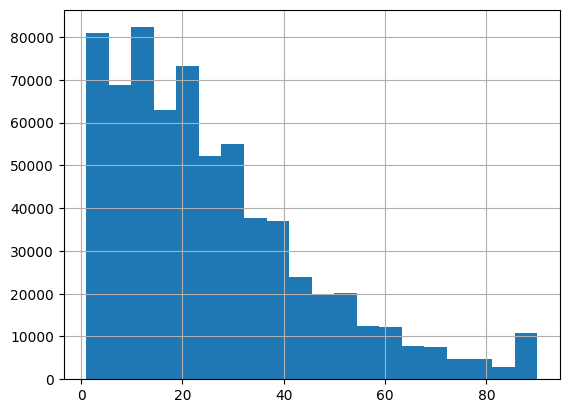

In [19]:
ing_list_len_ss.clip(upper=90).hist(bins=20)

In [20]:
from collections import Counter

In [21]:
ing_counter = Counter(i for l in df.ingredients_list for i in l)
ing_counter_ss = pd.Series(ing_counter).sort_values(ascending=False)
ing_counter_ss.iloc[:50]

en:salt                     388509
en:added-sugar              378285
en:disaccharide             341857
en:sugar                    331815
en:flavouring               279208
en:water                    275823
en:oil-and-fat              269256
en:vegetable-oil-and-fat    250294
en:dairy                    213632
en:vegetable                208318
en:cereal                   205446
en:natural-flavouring       182997
en:vegetable-oil            174740
en:flour                    169327
en:root-vegetable           167690
en:wheat                    160060
en:starch                   159985
en:fruit                    155962
en:monosaccharide           147367
en:spice                    146840
en:condiment                139475
en:glucose                  138180
en:cereal-flour             137703
en:e330                     136933
en:milk                     131877
en:wheat-flour              131081
en:e322                     101932
en:colour                    95261
en:e322i            

In [22]:
ing_counter_ss[~ing_counter_ss.index.str.startswith('en:')].iloc[:10]

fr:ingredients                       2331
fr:matiere-grasse-de-lait-anhydre    1651
de:weichweizenmehl                   1379
fr:boyau-naturel-de-porc             1359
fr:salt                              1018
fr:denree-alimentaire-colorante       993
fr:couenne-de-porc                    986
fr:water                              957
fr:lait-ecreme-reconstitue            953
fr:ail-seche                          936
dtype: int64

In [23]:
df['ingredients_list'] = df['ingredients_list'].map(lambda l: [i for i in l if i.startswith('en:')])

In [24]:
ing_counter = Counter(i for l in df.ingredients_list for i in l)
ing_counter_ss = pd.Series(ing_counter).sort_values(ascending=False)

In [25]:
ing_counter_ss.describe(percentiles=[0.5, 0.9, 0.95, 0.99])

count    258320.000000
mean         64.651378
std        2523.171115
min           1.000000
50%           1.000000
90%           4.000000
95%          10.000000
99%         146.810000
max      388509.000000
dtype: float64

In [26]:
ing_counter_ss[ing_counter_ss >= param_minimum_ingredient_freq].shape

(8059,)

In [27]:
ingredient_set = ing_counter_ss[ing_counter_ss >= param_minimum_ingredient_freq].index
len(ingredient_set)

8059

In [28]:
df['ingredients_list'] = df['ingredients_list'].map(lambda l: [i for i in l if i in ingredient_set])

In [29]:
df.shape

(676995, 3)

In [30]:
df = df[df.ingredients_list.map(lambda l: len(l) > 0)].copy()
df.shape

(675675, 3)

<AxesSubplot:>

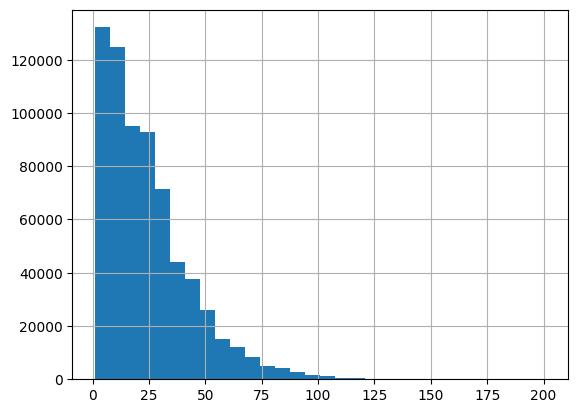

In [31]:
ing_list_len_ss = df.ingredients_list.map(len)
ing_list_len_ss.hist(bins=30)

In [32]:
ing_list_len_ss.value_counts()[1]

6059

In [33]:
df.sample(n=10)

,product_name,nova_group,ingredients_list
code,,,
0733426025486,Amestec jam,4,"[en:sugar, en:added-sugar, en:disaccharide, en..."
41190463183,"Shoprite, kitchen, linguine",1,"[en:durum-wheat-semolina, en:cereal, en:wheat,..."
3257984614663,Ravioli bolognaise,4,"[en:water, en:ravioli, en:dough, en:pasta, en:..."
3222474999681,Recette gourmande Minestrone,3,"[en:vegetable, en:water, en:parmesan, en:dairy..."
3770002953273,Confiture framboise épépinée,3,"[en:raspberry, en:fruit, en:berries, en:sugar,..."
21130081462,Flavored salad with chicken,4,"[en:white-meat-chicken, en:green-leaf-lettuce,..."
03186527,Juice drink from concentrate,4,"[en:filtered-water, en:water, en:cranberry, en..."
0416999764050,Beef Jerky,4,"[en:beef, en:animal, en:sugar, en:added-sugar,..."
5942289002854,Ciao Orange Juice,4,"[en:water, en:sugar, en:added-sugar, en:disacc..."


## Split data

Split into train and test and save datasets model building pipeline inputs

In [34]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [35]:
train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [36]:
train_indices, test_indices = next(
    train_test_split.split(np.zeros(df.shape[0]), df.nova_group)
)

In [37]:
df_train = df.iloc[train_indices]
df_test = df.iloc[test_indices]

In [38]:
pd.DataFrame({
    name : _df.nova_group.value_counts(normalize=True)
    for name, _df in zip(['train', 'test'], [df_train, df_test])
})

,train,test
4,0.670850,0.670848
3,0.201402,0.201399
1,0.108525,0.108529
2,0.019223,0.019225


In [39]:
def save_input_dataset(df:pd.DataFrame, out_path:Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(out_path, index=True)

In [40]:
save_input_dataset(df_train, Path(OUTPUT_DIR) / 'train.parquet')

In [41]:
save_input_dataset(df_test, Path(OUTPUT_DIR) / 'test.parquet')

In [42]:
!ls -alh $OUTPUT_DIR

total 95944
drwxr-xr-x  4 rgareev  staff   128B Sep  9 17:46 .
drwxr-xr-x  4 rgareev  staff   128B Sep  9 17:46 ..
-rw-r--r--  1 rgareev  staff   9.5M Sep  9 17:46 test.parquet
-rw-r--r--  1 rgareev  staff    37M Sep  9 17:46 train.parquet
